* Data preprocessing
* feature extraction using VGG-16
* training

In [34]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr

wr.filterwarnings("ignore")

# Data preparation

In [35]:
train_path=r'../input/pedestrian-detection/Train/Train/JPEGImages'
train_annot=r'../input/pedestrian-detection/Train/Train/Annotations'

test_path=r'../input/pedestrian-detection/Test/Test/JPEGImages'
test_annot=r'../input/pedestrian-detection/Test/Test/Annotations'

val_path=r'../input/pedestrian-detection/Val/Val/JPEGImages'
val_annot=r'../input/pedestrian-detection/Val/Val/Annotations'

This function "creatingInfoData" creates pandas dataframe from annotation file.

In [36]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'ymax':[],'name':[]
                ,'label':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)   #for parsing the file.
        for element in dat.iter():    #iter() method returns the iterator object

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text                 
                        information['label'] += [name]
                        information['name'] +=[file.split('/')[-1][0:-4]]

                    if 'bndbox'==attribute.tag:    #for bounding box in annotation file.
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]
                     
    return pd.DataFrame(information)   #returning a pandas dataframe


Here we are creating dataframe for train,test and validation dataset.

In [37]:
train_info=creatingInfoData(train_annot)
test_info=creatingInfoData(test_annot)
val_info=creatingInfoData(val_annot)

In [38]:
train_info.head(20)

,xmin,ymin,xmax,ymax,name,label
0,158,44,289,167,image (1),person
1,185,56,287,241,image (10),person
2,2,86,344,374,image (100),person
3,220,95,500,290,image (100),person
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person
7,1,19,335,338,image (102),person
8,261,23,500,338,image (102),person
9,77,46,202,464,image (103),person


> It 's normally that there are multi objects in specific images so that shape of info 2000 and data 900 

**Let's see an example**

In [39]:
train_info.loc[train_info['name']=='image (101)']

,xmin,ymin,xmax,ymax,name,label
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person


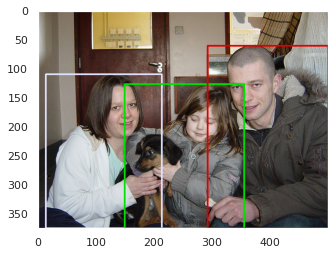

In [40]:
img=cv2.imread(train_path+'/image (101).jpg',cv2.IMREAD_COLOR)  #reading the image using cv2.imread
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)   

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

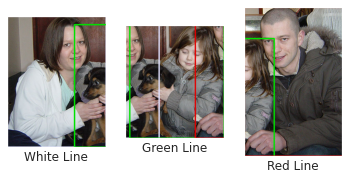

In [41]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[110:375,13:213])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')

plt.subplot(1,3,2)
plt.imshow(img[127:375,139:355])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,3)
plt.imshow(img[61:375,292:500])   
plt.xticks([])
plt.yticks([])
plt.xlabel('Red Line')

plt.show()

#### Splitting objects for the image 

In [42]:
def croppingFromImage(path,Data_information):   #this function here obtains cropped image 
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)   #reading the image from the data_information datatset.
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #converting the color of that image from BGR to RGB.if we want to use both the Pillow function(PIL) and the OpenCV function, you need to convert BGR and RGB.
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]  #from image we are extracting the area enclsed by bounding box.
        cropped_image.append(img_)
        
        label.append(Data_information['label'][i])
    return cropped_image , label      #returning cropped image along with its label

In [43]:
trainImage , trainLabel =croppingFromImage(train_path,train_info)
testImage , testLabel =croppingFromImage(test_path,test_info)
valImage,valLabel=croppingFromImage(val_path,val_info)

### As we can see that Data must be reshaped 

In [44]:
trainShapes=[]
testShapes=[]
for i in trainImage :
    trainShapes.append(i.shape)
for i in testImage :
    testShapes.append(i.shape)
   

### Most frequent shapes

In [45]:
pd.Series(trainShapes).value_counts()[:10]

(374, 499, 3)    4
(162, 58, 3)     2
(280, 252, 3)    2
(151, 60, 3)     2
(358, 271, 3)    2
(95, 43, 3)      2
(44, 34, 3)      2
(101, 49, 3)     2
(101, 32, 3)     2
(284, 92, 3)     2
dtype: int64

In [46]:
pd.Series(testShapes).value_counts()[:10]

(85, 52, 3)      2
(128, 58, 3)     2
(128, 47, 3)     2
(120, 37, 3)     2
(171, 74, 3)     2
(105, 81, 3)     2
(506, 449, 3)    1
(225, 128, 3)    1
(180, 94, 3)     1
(187, 85, 3)     1
dtype: int64

In [47]:
def resizing(data,size):  #for resizing
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))
        
    return resizing   

In [48]:
s=140
X_train,X_test,X_Val=resizing(trainImage,s),resizing(testImage,s),resizing(valImage,s)

In [49]:
labeling=preprocessing.LabelEncoder()    #for conerting text tu numerical data we are using LabelEncoder. Numbers are the only form of data that is understood by the model.
y_train=labeling.fit_transform(trainLabel)  
y_test=labeling.fit_transform(testLabel)
y_val=labeling.fit_transform(valLabel)

In [50]:
labeling.classes_   #all the classes

array(['person', 'person-like'], dtype='<U11')

# Feature Extraction

### I will use VGG-16 as a Feature extractor

In [51]:
VGG_Model=VGG16(weights='imagenet',include_top=False,input_shape=(s,s,3))

In [52]:
for layer in VGG_Model.layers:
    layer.trainable=False    #freezing the layers i.e no updation will occur at the time of training.

In [53]:
VGG_Model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140, 140, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 140, 140, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 140, 140, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 70, 70, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 70, 70, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 70, 70, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 35, 35, 128)       0     

In [54]:
### Scaling
X_train,X_test,X_Val=np.asarray(X_train).astype(np.float32),np.asarray(X_test).astype(np.float32),np.asarray(X_Val).astype(np.float32)
X_train,X_test,X_Val=X_train/255.0,X_test/255.0,X_Val/255.0

In [55]:
print(X_train.shape)
print(X_test.shape)

(2066, 140, 140, 3)
(595, 140, 140, 3)


In [56]:
Training=np.concatenate((X_train,X_test))
Training_lbl=np.concatenate((y_train,y_test))

In [57]:
print(Training.shape)
print(Training_lbl.shape)

(2661, 140, 140, 3)
(2661,)


In [58]:
features_extracted=VGG_Model.predict(Training)
features_extracted_test=VGG_Model.predict(X_Val)

2022-11-23 12:42:29.493254: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 625867200 exceeds 10% of free system memory.
2022-11-23 12:42:30.389742: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 625867200 exceeds 10% of free system memory.


In [59]:
flatten=features_extracted.reshape(features_extracted.shape[0],-1)
flatten_test=features_extracted_test.reshape(features_extracted_test.shape[0],-1)

In [60]:
print('train shape before Flatten ',features_extracted.shape)
print('train shape after Flatten ',flatten.shape)
print("="*50)
print('test shape before Flatten ',features_extracted_test.shape)
print('test shape after Flatten ',flatten_test.shape)


train shape before Flatten  (2661, 4, 4, 512)
train shape after Flatten  (2661, 8192)
test shape before Flatten  (333, 4, 4, 512)
test shape after Flatten  (333, 8192)


# Training

In [61]:
model=Sequential()   #Sequential API
model.add(Dense(64,input_shape=flatten.shape))
model.add(Activation('relu'))
model.add(Dropout(.7))

model.add(Dense(2))
model.add(Activation('sigmoid'))


In [62]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [63]:
fitting=model.fit(flatten,Training_lbl,batch_size=32,epochs=100,validation_data=(flatten_test,y_val))

Epoch 1/100
84/84 [==============================] - 1s 6ms/step - loss: 0.6308 - accuracy: 0.6712 - val_loss: 0.3981 - val_accuracy: 0.8438
Epoch 2/100
84/84 [==============================] - 0s 4ms/step - loss: 0.4755 - accuracy: 0.7700 - val_loss: 0.3395 - val_accuracy: 0.8769
Epoch 3/100
84/84 [==============================] - 0s 4ms/step - loss: 0.4181 - accuracy: 0.8016 - val_loss: 0.3271 - val_accuracy: 0.8679
Epoch 4/100
84/84 [==============================] - 0s 4ms/step - loss: 0.4024 - accuracy: 0.8050 - val_loss: 0.2990 - val_accuracy: 0.8559
Epoch 5/100
84/84 [==============================] - 0s 4ms/step - loss: 0.3802 - accuracy: 0.8219 - val_loss: 0.2969 - val_accuracy: 0.8529
Epoch 6/100
84/84 [==============================] - 0s 5ms/step - loss: 0.3445 - accuracy: 0.8470 - val_loss: 0.2871 - val_accuracy: 0.8559
Epoch 7/100
84/84 [==============================] - 0s 5ms/step - loss: 0.3456 - accuracy: 0.8320 - val_loss: 0.2806 - val_accuracy: 0.8619
Epoch 8/100
8

# Evaluation

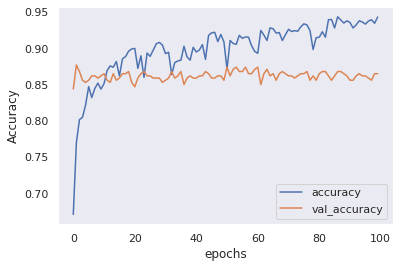

In [64]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'],loc='lower right')
plt.show()